In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [5]:
train.shape, test.shape

((26049, 15), (6512, 14))

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum()
test.isnull().sum()

### outlier

### education

In [6]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [7]:
df = pd.concat([train, test])

df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [8]:
train['Priority'] = 0
train.loc[(train['marital_status'] == 'Never-married')
          & ((train['relationship'] == 'Other-relative') 
             | (train['relationship'] == 'Own-child')), 'Priority'] = 1
train.loc[(train['marital_status'] =='Separated') & (train['relationship'] == 'Unmarried'), 'Priority'] = 2
train.loc[(train['marital_status'] =='Widowed') | (train['marital_status'] == 'Married-spouse-absent'), 'Priority'] = 3
train.loc[(train['relationship'] =='Not-in-family') | (train['marital_status'] == 'Divorced'), 'Priority'] = 4
train.loc[(train['relationship'] =='Husband') | (train['marital_status'] == 'Married-civ-spouse'), 'Priority'] = 5
train.loc[(train['relationship'] =='Wife') | (train['marital_status'] == 'Married-AF-spouse'), 'Priority'] = 6

In [9]:
test['Priority'] = 0
test.loc[(test['marital_status'] == 'Never-married')
          & ((test['relationship'] == 'Other-relative') 
             | (test['relationship'] == 'Own-child')), 'Priority'] = 1
test.loc[(test['marital_status'] =='Separated') & (test['relationship'] == 'Unmarried'), 'Priority'] = 2
test.loc[(test['marital_status'] =='Widowed') | (test['marital_status'] == 'Married-spouse-absent'), 'Priority'] = 3
test.loc[(test['relationship'] =='Not-in-family') | (test['marital_status'] == 'Divorced'), 'Priority'] = 4
test.loc[(test['relationship'] =='Husband') | (test['marital_status'] == 'Married-civ-spouse'), 'Priority'] = 5
test.loc[(test['relationship'] =='Wife') | (test['marital_status'] == 'Married-AF-spouse'), 'Priority'] = 6

In [ ]:
train[['marital_status','relationship','Priority']]

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [10]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num','Priority']
          #, ignore_features =tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 7.85 s


In [11]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8653,0.9215,0.6468,0.7613,0.6992,0.6132,0.6167,0.2969
1,Extreme Gradient Boosting,0.8638,0.9197,0.6481,0.7555,0.6974,0.6102,0.6134,2.1512
2,CatBoost Classifier,0.8661,0.9241,0.6361,0.7712,0.6968,0.6119,0.6168,10.7809
3,Gradient Boosting Classifier,0.8631,0.9184,0.6070,0.7790,0.6821,0.5966,0.6043,2.0659
4,Ada Boost Classifier,0.8561,0.9114,0.6164,0.7451,0.6745,0.5832,0.5876,0.7158
5,Linear Discriminant Analysis,0.8460,0.9001,0.5918,0.7221,0.6500,0.5526,0.5573,0.1726
6,Extra Trees Classifier,0.8375,0.8833,0.6008,0.6892,0.6417,0.5373,0.5396,0.5225
7,Random Forest Classifier,0.8406,0.8737,0.5587,0.7208,0.6291,0.5296,0.5369,0.1269


In [12]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8621,0.9215,0.6359,0.7558,0.6907,0.6028,0.6065
1,0.8602,0.9172,0.6408,0.7458,0.6893,0.5997,0.6026
2,0.8559,0.9216,0.6197,0.7422,0.6755,0.5838,0.5877
3,0.8742,0.9310,0.6386,0.8008,0.7106,0.6315,0.6381
4,0.8695,0.9249,0.6586,0.7694,0.7097,0.6262,0.6293
Mean,0.8644,0.9232,0.6387,0.7628,0.6951,0.6088,0.6129
SD,0.0066,0.0046,0.0124,0.0212,0.0133,0.0177,0.0184


In [13]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8706,0.9287,0.6511,0.778,0.7089,0.6265,0.6306


In [14]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 33s


In [15]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [16]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [17]:
submission.to_csv('output/20201019-3.csv')

In [18]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8708,0.9212,0.6343,0.7903,0.7038,0.6224,0.6286
1,0.8598,0.9148,0.6505,0.7390,0.6919,0.6017,0.6037
2,0.8583,0.9157,0.6602,0.7286,0.6927,0.6009,0.6021
3,0.8558,0.9123,0.6299,0.7348,0.6783,0.5861,0.5890
4,0.8527,0.9080,0.6343,0.7232,0.6759,0.5811,0.5832
5,0.8723,0.9295,0.6570,0.7808,0.7135,0.6321,0.6360
6,0.8770,0.9333,0.6602,0.7969,0.7221,0.6440,0.6487
7,0.8668,0.9200,0.6311,0.7769,0.6964,0.6123,0.6177
8,0.8589,0.9219,0.6472,0.7380,0.6897,0.5989,0.6010
9,0.8660,0.9200,0.6764,0.7464,0.7097,0.6228,0.6241


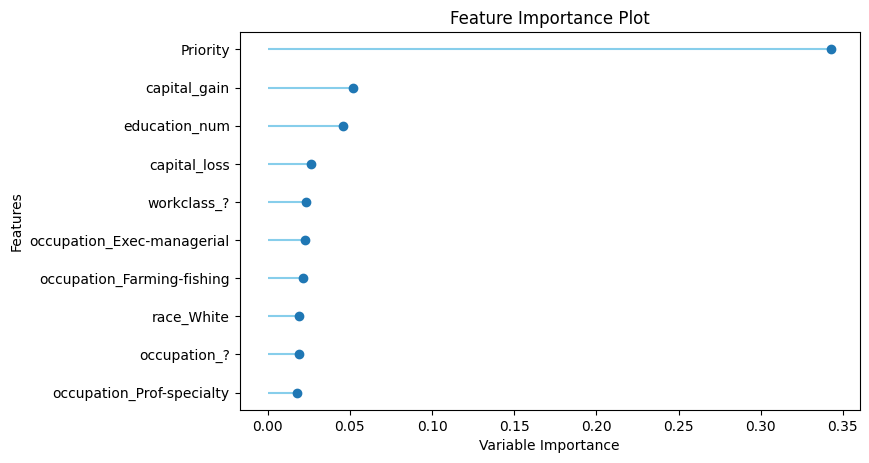

In [19]:
plot_model(estimator = xgboost, plot = 'feature')

In [20]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8645,0.9238,0.6472,0.7576,0.6981,0.6114,0.6146
1,0.8598,0.9187,0.6602,0.7338,0.6951,0.6044,0.6058
2,0.8630,0.9167,0.6602,0.7445,0.6998,0.6115,0.6133
3,0.8621,0.9124,0.6396,0.7519,0.6912,0.6032,0.6064
4,0.8550,0.9101,0.6117,0.7441,0.6714,0.5795,0.5841
5,0.8668,0.9303,0.6505,0.7643,0.7028,0.6177,0.6210
6,0.8762,0.9360,0.6537,0.7984,0.7189,0.6405,0.6457
7,0.8636,0.9198,0.6375,0.7606,0.6937,0.6068,0.6107
8,0.8715,0.9262,0.6408,0.7888,0.7071,0.6259,0.6315
9,0.8707,0.9209,0.6667,0.7687,0.7140,0.6310,0.6337


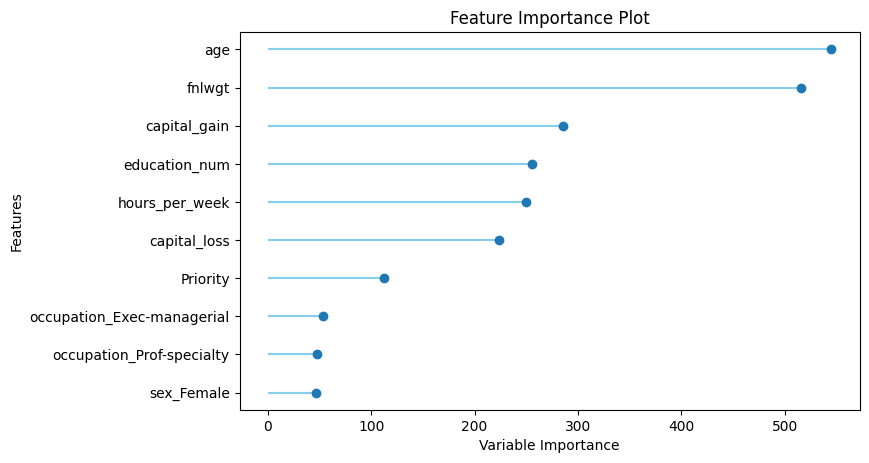

In [21]:
plot_model(estimator = lightgbm, plot = 'feature')